# Walmart EDA

In [1]:
! pip install --upgrade pip
! pip install joblib

    100% |████████████████████████████████| 1.4MB 21.0MB/s ta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
    100% |████████████████████████████████| 286kB 25.5MB/s ta 0:00:01


In [4]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime

import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [5]:
# load dataframes
train = pd.read_csv("walmart_train.csv")
test = pd.read_csv("test.csv")


In [6]:
# convert date to datetime 
train["Date"] = pd.to_datetime(train["Date"], format="%Y-%m-%d")
# feature enginner
train["year"] = pd.DatetimeIndex(train["Date"]).year
train["month"] = pd.DatetimeIndex(train["Date"]).month
train["day"] = pd.DatetimeIndex(train["Date"]).day
train["week"] = pd.DatetimeIndex(train["Date"]).week
train["weekday"] = pd.DatetimeIndex(train["Date"]).dayofweek 
#set . index
train.set_index('Date', inplace=True)
train.head()

,Store,Dept,Weekly_Sales,IsHoliday,year,month,day,week,weekday
Date,,,,,,,,,
2010-02-05,1,1,24924.50,False,2010,2,5,5,4
2010-02-12,1,1,46039.49,True,2010,2,12,6,4
2010-02-19,1,1,41595.55,False,2010,2,19,7,4
2010-02-26,1,1,19403.54,False,2010,2,26,8,4
2010-03-05,1,1,21827.90,False,2010,3,5,9,4


In [7]:
# stores & Departments
print('Depts',train.Dept.min(), '-',train.Dept.max())
print('Stores',train.Store.min(), '-',train.Store.max())
print('Years', train.year.min(), '-', train.year.max())

Depts 1 - 99
Stores 1 - 45
Years 2010 - 2012


## Forecast Store 1, Department 1

In [8]:
train_1_1 = train[(train.Store==1) & (train.Dept==1)]["Weekly_Sales"].groupby(["Date"]).agg('sum')
train_1_1.head()

Date
2010-02-05    24924.50
2010-02-12    46039.49
2010-02-19    41595.55
2010-02-26    19403.54
2010-03-05    21827.90
Name: Weekly_Sales, dtype: float64

In [24]:
train_1_1.index

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=143, freq='W-FRI')

In [23]:
train_1_1 = train_1_1.asfreq('W-FRI')

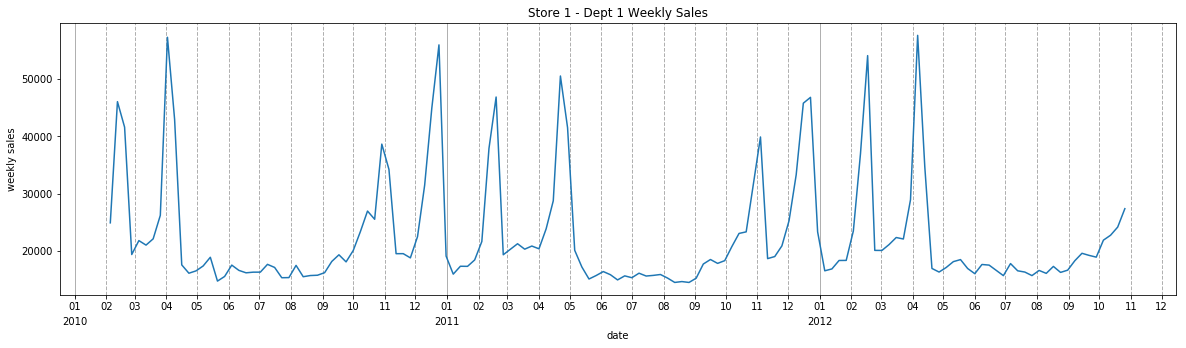

In [25]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(train_1_1)
    
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax.xaxis.set_minor_locator(mdates.YearLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.grid(which='minor', linestyle='-', linewidth=1)
ax.xaxis.grid(which='major', linestyle='--', linewidth=1)
ax.tick_params(axis='x', which='minor', pad=20)

plt.title('Store 1 - Dept 1 Weekly Sales')
plt.xlabel('date')
plt.ylabel('weekly sales')
plt.show()

## Plot ACF and PACF

In [26]:
from statsmodels.graphics import tsaplots

def plot_correlations(data):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,8))

    tsaplots.plot_acf(data,ax = ax1, lags=60)
    tsaplots.plot_pacf(data,ax = ax2, lags=60, method='ols')

    for ax in [ax1, ax2]:
        ax.set_xticks(range(0,61))
        ax.grid(axis='x')
        ax.set_ylim(bottom=-1, top=1)

    plt.show()

#### Original Data

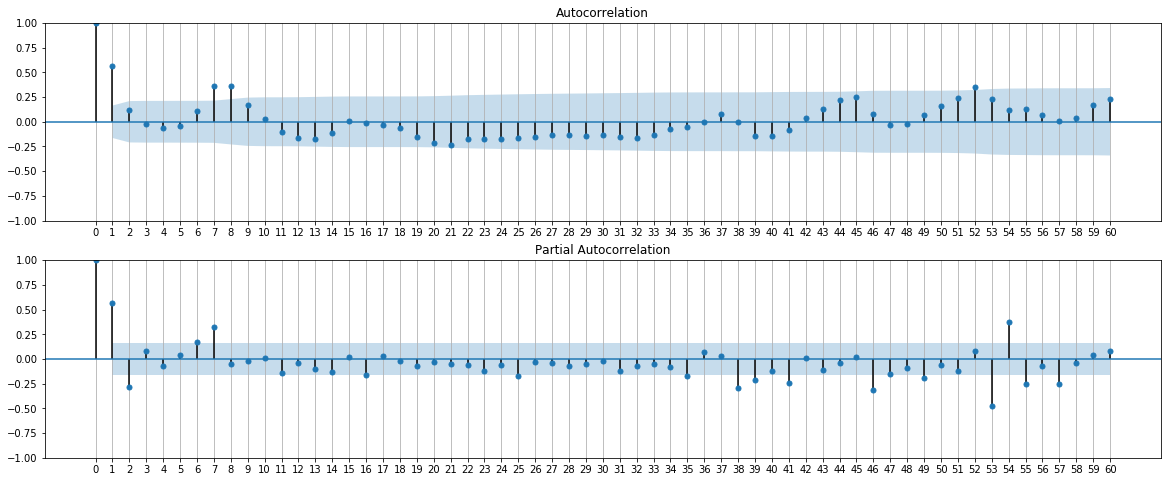

In [27]:
plot_correlations(train_1_1)

## Test for Stationarity

[here](https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000) is a good article on stationarity using Dickey-Fuller.

In [13]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid()
    plt.show()
    
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)
    

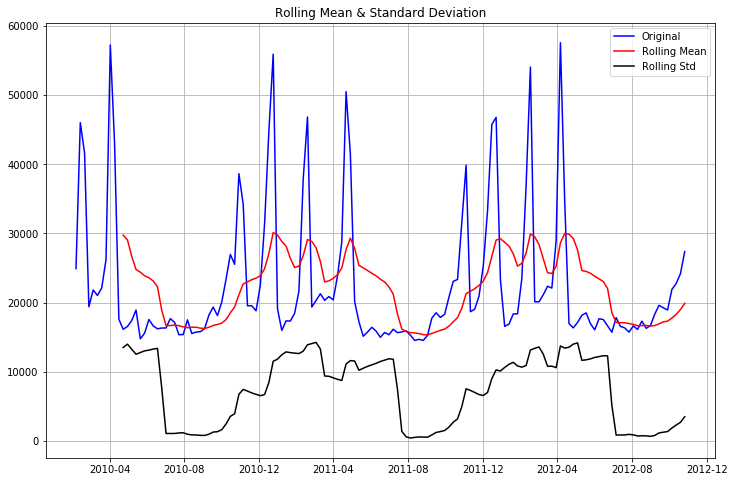

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.522164
P-Value                   0.110174
# Lags Used               6.000000
# Observations Used     136.000000
Critical Value (1%)      -3.479372
Critical Value (5%)      -2.883037
Critical Value (10%)     -2.578234
dtype: float64
Is the time series stationary? False


In [28]:
test_stationarity(train_1_1)

sTest = StationarityTests()
sTest.ADF_Stationarity_Test(train_1_1, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary)) 

### Perform 1st order differencing

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.104431e+01
P-Value                 5.269934e-20
# Lags Used             5.000000e+00
# Observations Used     1.360000e+02
Critical Value (1%)    -3.479372e+00
Critical Value (5%)    -2.883037e+00
Critical Value (10%)   -2.578234e+00
dtype: float64
Is the time series stationary? True


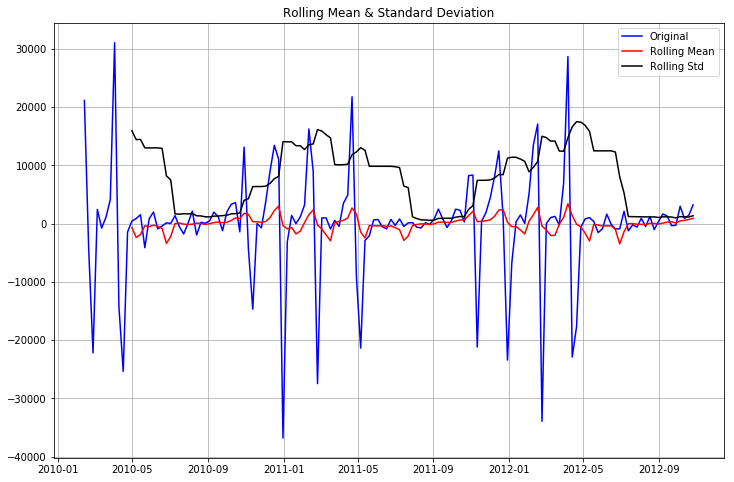

In [29]:
first_diff = train_1_1 - train_1_1.shift(1)
first_diff = first_diff.dropna(inplace=False)

sTest = StationarityTests()
sTest.ADF_Stationarity_Test(first_diff, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary)) 

test_stationarity(first_diff)

### Perform Seasonal Differencing

In [30]:
p = {}
for n in range(1,54):
    seasonal_diff = first_diff - first_diff.shift(n)
    seasonal_diff = seasonal_diff.dropna(inplace=False)

    sTest = StationarityTests()
    sTest.ADF_Stationarity_Test(seasonal_diff, printResults = False)
    
    p[n] = sTest.pValue

n = min(p, key=p.get)
print(n)

28


Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.076775e+01
P-Value                 2.428079e-19
# Lags Used             5.000000e+00
# Observations Used     1.080000e+02
Critical Value (1%)    -3.492401e+00
Critical Value (5%)    -2.888697e+00
Critical Value (10%)   -2.581255e+00
dtype: float64
Is the time series stationary? True


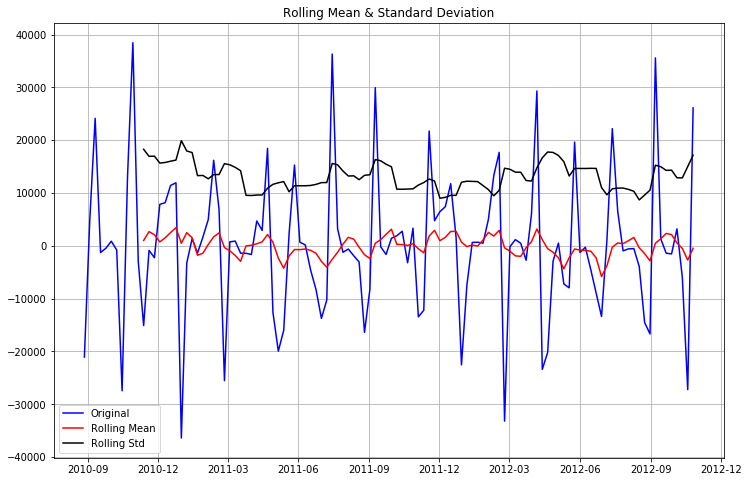

In [31]:
seasonal_diff = first_diff - first_diff.shift(n)
seasonal_diff = seasonal_diff.dropna(inplace=False)

sTest = StationarityTests()
sTest.ADF_Stationarity_Test(seasonal_diff, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary)) 

test_stationarity(seasonal_diff)

# Find a Model - Grid Search SARIMA



Tutorial [here](https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/)

In [32]:
# one-step sarima forecast
def sarima_forecast(history, config):
        order, sorder, trend = config
        # define model
        model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
        # fit model
        model_fit = model.fit(disp=False)
        # make one step forecast
        yhat = model_fit.predict(len(history), len(history))
        return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
        return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
        return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
        predictions = list()
        # split dataset
        train, test = train_test_split(data, n_test)
        # seed history with training dataset
        history = [x for x in train]
        # step over each time-step in the test set
        for i in range(len(test)):
            # fit model and make forecast for history
            yhat = sarima_forecast(history, cfg)
            # store forecast in list of predictions
            predictions.append(yhat)
            # add actual observation to history for the next loop
            history.append(test[i])
        # estimate prediction error
        error = measure_rmse(test, predictions)
        return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
        
        result = None
        # convert config to a key
        key = str(cfg)
        #print("now scoing {}".format(cfg))
        # show all warnings and fail on exception if debugging
        if debug:
            result = walk_forward_validation(data, n_test, cfg)
        else:
            # one failure during model validation suggests an unstable config
            try:
                # never show warnings when grid searching, too noisy
                with catch_warnings():
                    filterwarnings("ignore")
                    result = walk_forward_validation(data, n_test, cfg)
            except:
                print("exception on cfg {}".format(key))
                error = None
        # check for an interesting result
        if result is not None:
            print(' > Model[%s] %.3f' % (key, result))
        return (key, result)

    
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=False):
        scores = None
        if parallel:
            # execute configs in parallel
            executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
            tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
            scores = executor(tasks)
        else:
            scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
        # remove empty results
        scores = [r for r in scores if r[1] != None]
        # sort configs by error, asc
        scores.sort(key=lambda tup: tup[1])
        return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
        models = list()
        # define config lists
        p_params = [0,1,2]
        d_params = [0,1,2]
        q_params = [0,1,2]
        t_params = ['n']
        P_params = [0]
        D_params = [2]
        Q_params = [0]
        m_params = seasonal
        # create config instances
        for p in p_params:
            for d in d_params:
                for q in q_params:
                    for t in t_params:
                        for P in P_params:
                            for D in D_params:
                                for Q in Q_params:
                                    for m in m_params:
                                        cfg = [(p,d,q), (P,D,Q,m), t]
                                        models.append(cfg)
        
        return models

#### SARIMA(0,1,0)(0,2,0)52

In [33]:
model = SARIMAX(train_1_1, order=(0,1,0), seasonal_order=(0,2,0,52),
                trend='n', enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()

In [34]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(0, 1, 0)x(0, 2, 0, 52)   Log Likelihood                -415.101
Date:                            Mon, 01 Apr 2019   AIC                            832.202
Time:                                    17:08:05   BIC                            833.813
Sample:                                02-05-2010   HQIC                           832.770
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.202e+08   1.77e+07     12.406      0.000    1.85e+08    2.55e+08
===================================================================================
Ljung-Box (Q):                       28.96   Jarque-Bera (JB):                77.77
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [126]:
test = pd.read_csv("test.csv")
test_1_1 = test[["Date"]][(test.Store==1)&(test.Dept==1)]
test_1_1_array = test_1_1["Date"].values
test_1_1_dates = test_1_1_array.astype('datetime64')

In [127]:
preds = []
for t in test_1_1_array:
    p = model_fit.predict(t)
    preds.append(p.values[0])

In [128]:
test_1_1_df = pd.DataFrame(preds, index=test_1_1_dates, columns=["Weekly_sales"])
test_1_1_df.head()

,Weekly_sales
2012-11-02,48405.18
2012-11-09,20701.63
2012-11-16,21420.42
2012-11-23,25874.15
2012-11-30,30941.36


In [129]:
hist_df = pd.DataFrame(train_1_1)
hist_df.head()

,Weekly_Sales
Date,
2010-02-05,24924.50
2010-02-12,46039.49
2010-02-19,41595.55
2010-02-26,19403.54
2010-03-05,21827.90


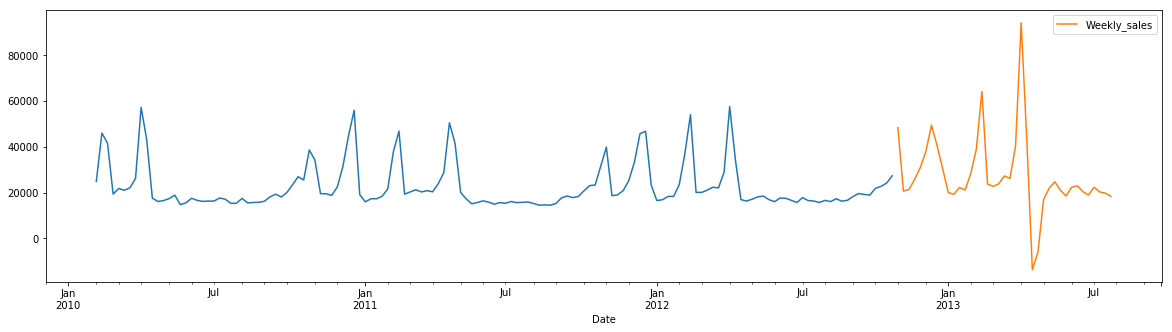

In [130]:
fig, ax = plt.subplots(figsize=(20,5))
train_1_1.plot(ax=ax)
test_1_1_df.plot(ax=ax)
plt.show()